# Simple neural style transfer

## Mount google drive

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check that GPU is fully used

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.9 GB  | Proc size: 150.9 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Imports first

In [0]:
import keras
from keras import backend as K
from PIL import Image
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from PIL import Image
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import os
from tensorboardcolab import *
import matplotlib.pyplot as plt
from IPython.display import Image as IImage
%matplotlib inline

Using TensorFlow backend.


## Here I define function which adds white noise to an image

In [0]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 0.1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def deprocess(x):
  x = np.copy(x)
  x = x.reshape((224, 224, 3))
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

## Image loading

In [0]:
style_img_pth = 'ZkGAEyGL_400x400.jpg'
if style_img_pth not in os.listdir():
  !wget https://pbs.twimg.com/profile_images/758657870686724096/ZkGAEyGL_400x400.jpg

content_img_pth = 'images-421.jpg'
if content_img_pth not in os.listdir():
  !wget https://404store.com/2018/12/19/images-421.jpg --no-check-certificate

In [0]:
content_img = image.load_img(content_img_pth, target_size=(224, 224))
content_img = image.img_to_array(content_img)
content_img = preprocess_input(content_img)

style_img = image.load_img(style_img_pth, target_size=(224, 224))
style_img = image.img_to_array(style_img)
style_img = preprocess_input(style_img)

outp_img = noisy(np.copy(content_img))

cont_tensor = K.constant(np.expand_dims(content_img, axis=0))
style_tensor = K.constant(np.expand_dims(style_img, axis=0))
outp_tensor = K.placeholder(shape=np.expand_dims(outp_img, axis=0).shape)

W0709 06:03:59.871886 139949413537664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



## Define loss function

In [0]:
def lossf(x, y):
  assert x.shape == y.shape
  return tf.math.reduce_mean(K.square(x - y))

In [0]:
def get_gram_matrix(x):
  x = K.reshape(x, (-1, 1))
  return K.dot(x, K.transpose(x))[:20000, :20000]

## Create necessary tensors


In [0]:
loss = K.variable(0.0, name='loss')
style_weight = K.constant(0.9)
content_weight = K.constant(0.1)


inp_tensor = K.concatenate((outp_tensor, cont_tensor, style_tensor), axis=0)

vgg19 = VGG19(
    weights='imagenet', include_top=False,
    input_tensor=inp_tensor
)

style_tensor = vgg19.get_layer('block5_pool').output
content_tensor = vgg19.get_layer('block5_conv2').output

outp_style = get_gram_matrix(style_tensor[0, :, :, :])
style_style = get_gram_matrix(style_tensor[2, :, :, :])

outp_content = content_tensor[0, :, :, :]
content_content = content_tensor[1, :, :, :]

loss_tensor = content_weight * lossf(content_content, outp_content) + style_weight * lossf(outp_style, style_style)

W0709 06:03:59.934195 139949413537664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 06:03:59.935757 139949413537664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 06:03:59.974478 139949413537664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0709 06:04:00.572416 139949413537664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0709 06:04:00.573995 139949413537664 d

## This is how we compute losses and gradients

In [0]:
grads = K.gradients([loss_tensor], [outp_tensor])  

loss_grad_func = K.function([outp_tensor], [loss_tensor, *grads])

def eval_loss_and_grads(x):
  temp = loss_grad_func([x.reshape((1, 224, 224, 3))])
  loss = temp[0]
  grads = temp[1:]
  return (loss, np.array(grads).flatten().astype('float64'))

class Evaluator(object):
  def __init__(self):
    self.history = []
    self.grad = None
    self.losses = None
    
  def loss(self, x):
    assert self.grad is None
    self.losses, self.grad = eval_loss_and_grads(x)
    self.history.append(self.losses/ (4.0 * (3 ** 2) * ((224 * 224) ** 2)))
    print(self.losses/ (4.0 * (3 ** 2) * ((224 * 224) ** 2)))
    return self.losses
  
  def grads(self, x):
    assert self.losses is not None
    temp = np.copy(self.grad)
    self.grad = None
    self.losses = None
    return temp

x = np.copy(outp_img)

evaluator = Evaluator()

## Minimize loss using scipy optimizer

In [0]:
EPOCHS = 30

for i in range(EPOCHS):
  print("EPOCH", i)
  x, min_val, info = fmin_l_bfgs_b(
    evaluator.loss,
    x.flatten(),
    fprime=evaluator.grads,
    maxfun=20
)

EPOCH 0
1.3570182109561498e-07
1.353582695627859e-07
1.340128318991708e-07
1.2899526634145254e-07
9.657922630338414e-08
9.064994813779805e-08
8.628874540665495e-08
8.451825093907746e-08
8.36387277683847e-08
8.320592395008628e-08
8.301374627595928e-08
8.285145225170844e-08
8.270182928289455e-08
8.26025349704973e-08
8.252461228944287e-08
8.244609699950323e-08
8.237333540310384e-08
8.231366507571455e-08
8.216789406465466e-08
8.206072882879084e-08
8.205533070058173e-08
EPOCH 1
8.205533070058173e-08
8.205054673067185e-08
8.203208427022015e-08
8.197169742481508e-08
8.172723009759667e-08
8.151370772889434e-08
8.132281224490084e-08
8.105322907565562e-08
8.08630501096779e-08
8.058403907180401e-08
8.025829812965287e-08
7.988848863585455e-08
7.954396737939508e-08
7.917369996054907e-08
7.880704206854948e-08
7.831451943668025e-08
7.761491232354371e-08
7.709670817752996e-08
7.584214439278833e-08
7.484358225911311e-08
7.403564085440279e-08
EPOCH 2
7.403564085440279e-08
7.401962963979453e-08
7.3959566

## Plot loss

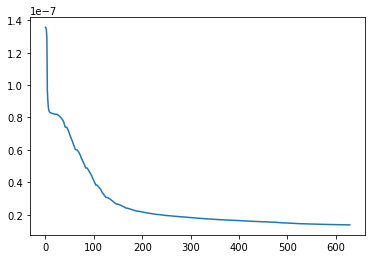

In [0]:
plt.plot(evaluator.history)

## Show pictures

Content image


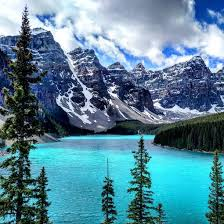

In [0]:
print("Content image")
IImage(filename=content_img_pth)

Style image


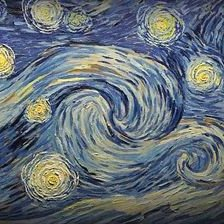

In [0]:
print("Style image")
IImage(filename=style_img_pth)

Output image


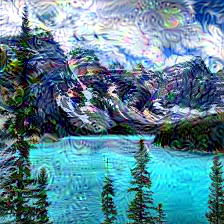

In [0]:
img = deprocess(x)
img = Image.fromarray(img, 'RGB')
op = '/content/drive/My Drive/sirius/gened.png'
SAVE = True
if SAVE:
  img.save(op)
print("Output image")
IImage(filename=op)